In [85]:
import warnings
warnings.filterwarnings('ignore') # Filter out warnings
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from scipy import stats
import math
from math import isnan
# loading machine learning required packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import time
# for multi-class logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [86]:
# Add Two Extra Columns: signs of mid-price and signs of spread crossing 
def AddMidPriceAndSpreadCrossing(df):   
    df2 = df.copy(deep=False)
    
    # 1) add mid-price movement column first    # criterion: [0: upward;  1: downward;  2: stationary] 
    midprices = []
    for index, row in df2.iterrows():
        midprices.append((row['P_ask_1'] + row['P_bid_1'])/2)
    df2['Mid_price'] = midprices
    # decide if mid-price moves up or down, or stays stationary
    midpriceMoves = [2]
    for i in range(1,len(midprices)):
        if (midprices[i] > midprices[i-1]):
            midpriceMoves.append(0)
        elif (midprices[i] < midprices[i-1]):
            midpriceMoves.append(1)
        else: 
            midpriceMoves.append(2)
    # checking 
    if (len(midpriceMoves)!=len(df2.index)):
        print('error! Lengths do not match.')
        return
    # good to go
    df2['MidPrice_Moves'] = midpriceMoves
    
    
    # 2) decide spread crossing movements   # criterion: [0: upward;  1: downward;  2: no spread crossing] 
    sprCros = [2]
    bestBids = df2['P_bid_1']
    bestAsks = df2['P_ask_1']
    for i in range(1,len(bestBids)):
        if (bestBids[i] > bestAsks[i-1]):
            sprCros.append(0)
        elif (bestAsks[i] < bestBids[i-1]):
            sprCros.append(1)
        elif ((bestAsks[i]>=bestBids[i-1])&(bestBids[i]<=bestAsks[i-1])):
            sprCros.append(2)
        else: 
            print(i,'error!')
    # checking 
    if (len(midpriceMoves)!=len(df2.index)):
        print('error! Lengths do not match.')
        return   
    # good to go
    df2['SpdCros_Moves'] = sprCros
    
    return df2

In [87]:
def PredictY(tradingDay_df,trainingTime_mins,predictionTime_mins,target_Y,C_param,NoCancel):
    ## return two things:
    train_accs, test_accs = [], []
    # make a copy of the dataframe
    df = tradingDay_df.copy(deep=False)
    st_time,ed_time  = int(list(df['Time_stamp'])[0]), int(list(df['Time_stamp'])[-1])  # in seconds
    ## st and ed denote the start time and end time for each training session
    st, ed = st_time, st_time + trainingTime_mins * 60 
    # when last prediction time is not beyond the total trading time window
    while (ed + predictionTime_mins*60 <= ed_time):
        if NoCancel:
            Xtrain = np.array(df[(df['Time_stamp']<=ed)&(df['Type']!=2)&(df['Type']!=3)]\
                  [df.columns.difference(['Time','Time_stamp', 'Unnamed: 0','MidPrice_Moves','SpdCros_Moves'])])
            ytrain = np.array(df[(df['Time_stamp']<=ed)&(df['Type']!=2)&(df['Type']!=3)][[target_Y]])
        else:
            Xtrain = np.array(df[(df['Time_stamp']<=ed)]\
                  [df.columns.difference(['Time','Time_stamp', 'Unnamed: 0','MidPrice_Moves','SpdCros_Moves'])])
            ytrain = np.array(df[(df['Time_stamp']<=ed)][[target_Y]])
        # train a model
        lr = LogisticRegression(penalty='l2',C=C_param,random_state=0)
        lr.fit(Xtrain,ytrain)
        # on training data
        yhat = lr.predict(Xtrain)
        train_accs.append("%.2f" % accuracy_score(ytrain,yhat))
        # move on to test set
        if NoCancel:
            Xtest = np.array(df[(df['Time_stamp']>ed)&(df['Time_stamp']<ed+predictionTime_mins*60)&(df['Type']!=2)&(df['Type']!=3)]\
                 [df.columns.difference(['Time','Time_stamp', 'Unnamed: 0','MidPrice_Moves','SpdCros_Moves'])])
        else: 
            Xtest = np.array(df[(df['Time_stamp']>ed)&(df['Time_stamp']<ed+predictionTime_mins*60)]\
                 [df.columns.difference(['Time','Time_stamp', 'Unnamed: 0','MidPrice_Moves','SpdCros_Moves'])])
        # on test set
        yhat_test = lr.predict(Xtest)
        if NoCancel:
            ytest = np.array(df[(df['Time_stamp']>ed)&(df['Time_stamp']<ed+predictionTime_mins*60)\
                               &(df['Type']!=2)&(df['Type']!=3)][[target_Y]])
        else:
            ytest = np.array(df[(df['Time_stamp']>ed)&(df['Time_stamp']<ed + predictionTime_mins*60)][[target_Y]])
        test_accs.append("%.2f" % accuracy_score(ytest,yhat_test))
        ### moving the training session forward
        st += trainingTime_mins * 60
        ed += trainingTime_mins * 60
    ### changing the type
    for index, item in enumerate(test_accs):
        test_accs[index] = float(item)
    for index, item in enumerate(train_accs):
        train_accs[index] = float(item)
    return test_accs

In [88]:
file_path = "Messages_10amTo4pm_GOOG.csv"
df = pd.read_csv(file_path)

In [89]:
df.head(5)

,Unnamed: 0,Time_stamp,Type,OrderID,V,P,Dir,Time,P_ask_1,V_ask_1,...,mid-price 3,bid-ask spread 4,mid-price 4,bid-ask spread 5,mid-price 5,Volts,N_OrderSubmit,Submit_rate,Cancel_rate,Execute_rate
0,10863,36000.047007,3,46516287,15,5761000,-1,2012-06-21 10:00:00.047007000,5759100,1,...,5758250.0,6100,5758050.0,7400,5758200.0,2015.280051,1544,50.69,44.58,4.73
1,10864,36000.047040,1,46531975,15,5755400,1,2012-06-21 10:00:00.047040000,5759100,1,...,5758250.0,5700,5758250.0,6900,5758450.0,2015.280051,1545,50.71,44.57,4.73
2,10865,36000.071749,3,46516015,15,5761100,-1,2012-06-21 10:00:00.071749000,5759100,1,...,5758250.0,6500,5758650.0,8000,5759000.0,2015.280051,1545,50.69,44.59,4.72
3,10866,36000.080965,1,46533758,15,5762500,-1,2012-06-21 10:00:00.080965000,5759100,1,...,5758250.0,6500,5758650.0,7500,5758750.0,2015.280051,1546,50.71,44.57,4.72
4,10867,36000.224963,3,46531975,15,5755400,1,2012-06-21 10:00:00.224962000,5759100,1,...,5758250.0,6900,5758450.0,8000,5758500.0,2015.280051,1545,50.69,44.59,4.72


In [90]:
df.columns

Index(['Unnamed: 0', 'Time_stamp', 'Type', 'OrderID', 'V', 'P', 'Dir', 'Time',
       'P_ask_1', 'V_ask_1', 'P_bid_1', 'V_bid_1', 'P_ask_2', 'V_ask_2',
       'P_bid_2', 'V_bid_2', 'P_ask_3', 'V_ask_3', 'P_bid_3', 'V_bid_3',
       'P_ask_4', 'V_ask_4', 'P_bid_4', 'V_bid_4', 'P_ask_5', 'V_ask_5',
       'P_bid_5', 'V_bid_5', 'Label', 'Level', 'bid-ask spread 1',
       'mid-price 1', 'd_P_ask_51', 'd_P_bid_51', 'd_P_ask_21', 'd_P_bid_21',
       'd_P_ask_32', 'd_P_bid_32', 'd_P_ask_43', 'd_P_bid_43', 'd_P_ask_54',
       'd_P_bid_54', 'Mean_P_ask', 'Mean_P_bid', 'Mean_V_ask', 'Mean_V_bid',
       'P_accu', 'V_accu', 'bid-ask spread 2', 'mid-price 2',
       'bid-ask spread 3', 'mid-price 3', 'bid-ask spread 4', 'mid-price 4',
       'bid-ask spread 5', 'mid-price 5', 'Volts', 'N_OrderSubmit',
       'Submit_rate', 'Cancel_rate', 'Execute_rate'],
      dtype='object')

In [91]:
# adding price movement column
df_withY = AddMidPriceAndSpreadCrossing(df)

In [92]:
df_withY.columns

Index(['Unnamed: 0', 'Time_stamp', 'Type', 'OrderID', 'V', 'P', 'Dir', 'Time',
       'P_ask_1', 'V_ask_1', 'P_bid_1', 'V_bid_1', 'P_ask_2', 'V_ask_2',
       'P_bid_2', 'V_bid_2', 'P_ask_3', 'V_ask_3', 'P_bid_3', 'V_bid_3',
       'P_ask_4', 'V_ask_4', 'P_bid_4', 'V_bid_4', 'P_ask_5', 'V_ask_5',
       'P_bid_5', 'V_bid_5', 'Label', 'Level', 'bid-ask spread 1',
       'mid-price 1', 'd_P_ask_51', 'd_P_bid_51', 'd_P_ask_21', 'd_P_bid_21',
       'd_P_ask_32', 'd_P_bid_32', 'd_P_ask_43', 'd_P_bid_43', 'd_P_ask_54',
       'd_P_bid_54', 'Mean_P_ask', 'Mean_P_bid', 'Mean_V_ask', 'Mean_V_bid',
       'P_accu', 'V_accu', 'bid-ask spread 2', 'mid-price 2',
       'bid-ask spread 3', 'mid-price 3', 'bid-ask spread 4', 'mid-price 4',
       'bid-ask spread 5', 'mid-price 5', 'Volts', 'N_OrderSubmit',
       'Submit_rate', 'Cancel_rate', 'Execute_rate', 'Mid_price',
       'MidPrice_Moves', 'SpdCros_Moves'],
      dtype='object')

### Testing the model for two different dataframes (i.e. different features included)

In [93]:
df_withY_simple = df_withY.drop(columns=['Label', 'Level',
                                         'Volts', 'N_OrderSubmit',
                                         'Submit_rate', 'Cancel_rate', 'Execute_rate'])
print("simple df and complicated df have {}, {} number of features respectively."
      .format(len(df_withY_simple.columns),len(df_withY.columns)))

simple df and complicated df have 57, 64 number of features respectively.


In [94]:
t = time.time()
##### testing two prediction models: testing 1st one, with cancellation information
test_accs_simple = PredictY(df_withY_simple,20,5,target_Y='MidPrice_Moves',C_param=0.1,NoCancel=False)

accs_table_simple = pd.DataFrame(columns = ['Training Session','Accuracy'])
accs_table_simple['Accuracy'] = test_accs_simple
times_st = ['10:00','10:20','10:40','11:00','11:20','11:40','12:00','12:20','12:40','1:00',
        '1:20','1:40','2:00','2:20','2:40','3:00','3:20']
times = []
for i in range(len(times_st)):
    if i != len(times_st)-1:
        times.append(times_st[i]+'-'+times_st[i+1])
    else:
        times.append(times_st[i]+'-'+'3:40')
        
accs_table_simple['Training Session'] = times
accs_table_simple
print('processing time is {} seconds.'.format(time.time()-t))

processing time is 18.580049753189087 seconds.


In [95]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# y = accs_table_simple["Accuracy"]
# x = np.arange(len(y))
# ax.plot(x, y)

# labels = accs_table_simple["Training Session"]
# plt.xticks(x, labels, rotation=60)
# plt.title('Prediction Accuarcy of Mid-Price Movement, No Cancellation Information')
# plt.ylim([0,1])
# plt.show()

In [96]:
# ##### testing two prediction models: testing 2nd one, with cancellation features
# Labels_rep = []
# # Change the old Label column into numerical representations
# for index, row in df_withY.iterrows():
#     if row['Label'] == 'la' or row['Label'] == 'lb':
#         Labels_rep.append(0)
#     elif row['Label'] == 'ma' or row['Label'] == 'mb':
#         Labels_rep.append(1)
#     elif row['Label'] == 'c' or row['Label'] == 'pc':
#         Labels_rep.append(2)
#     else:
#         Labels_rep.append(3)
# df_withY['Labels_rep'] = Labels_rep
# df_withY = df_withY.drop(columns=['Label'])
# test_accs = PredictY(df_withY,20,5,target_Y='MidPrice_Moves',C_param=0.1,NoCancel=False)

In [97]:
# accs_table = pd.DataFrame(columns = ['Training Session','Accuracy'])
# accs_table['Accuracy'] = test_accs
# times_st = ['10:00','10:20','10:40','11:00','11:20','11:40','12:00','12:20','12:40','1:00',
#         '1:20','1:40','2:00','2:20','2:40','3:00','3:20']        
# accs_table['Training Session'] = times
# accs_table

In [98]:
# for i in range(len(test_accs)):
#     F = True
#     if test_accs[i] != test_accs_simple[i]:
#         F = False
# if F:
#     print('all accuracies are equal!')

### Try alternating Training set, such that: it uses all messages, or only uses execution and submission msgs

In [99]:
t = time.time()
##### testing testing 3rd one, without cancellation messages
test_accs_simple_NoCancel = PredictY(df_withY_simple,20,5,target_Y='MidPrice_Moves',C_param=0.1,NoCancel=True)
# make plot
accs_table_simple_NoCancel = pd.DataFrame(columns = ['Training Session','Accuracy'])
accs_table_simple_NoCancel['Accuracy'] = test_accs_simple_NoCancel

accs_table_simple_NoCancel['Training Session'] = times
accs_table_simple_NoCancel
print('processing time is {} seconds.'.format(time.time()-t))

processing time is 10.880922317504883 seconds.


In [100]:
print(np.round(sum(test_accs_simple_NoCancel)/len(test_accs_simple_NoCancel),4))
print(np.round(sum(test_accs_simple)/len(test_accs_simple),4))

0.7576
0.8071


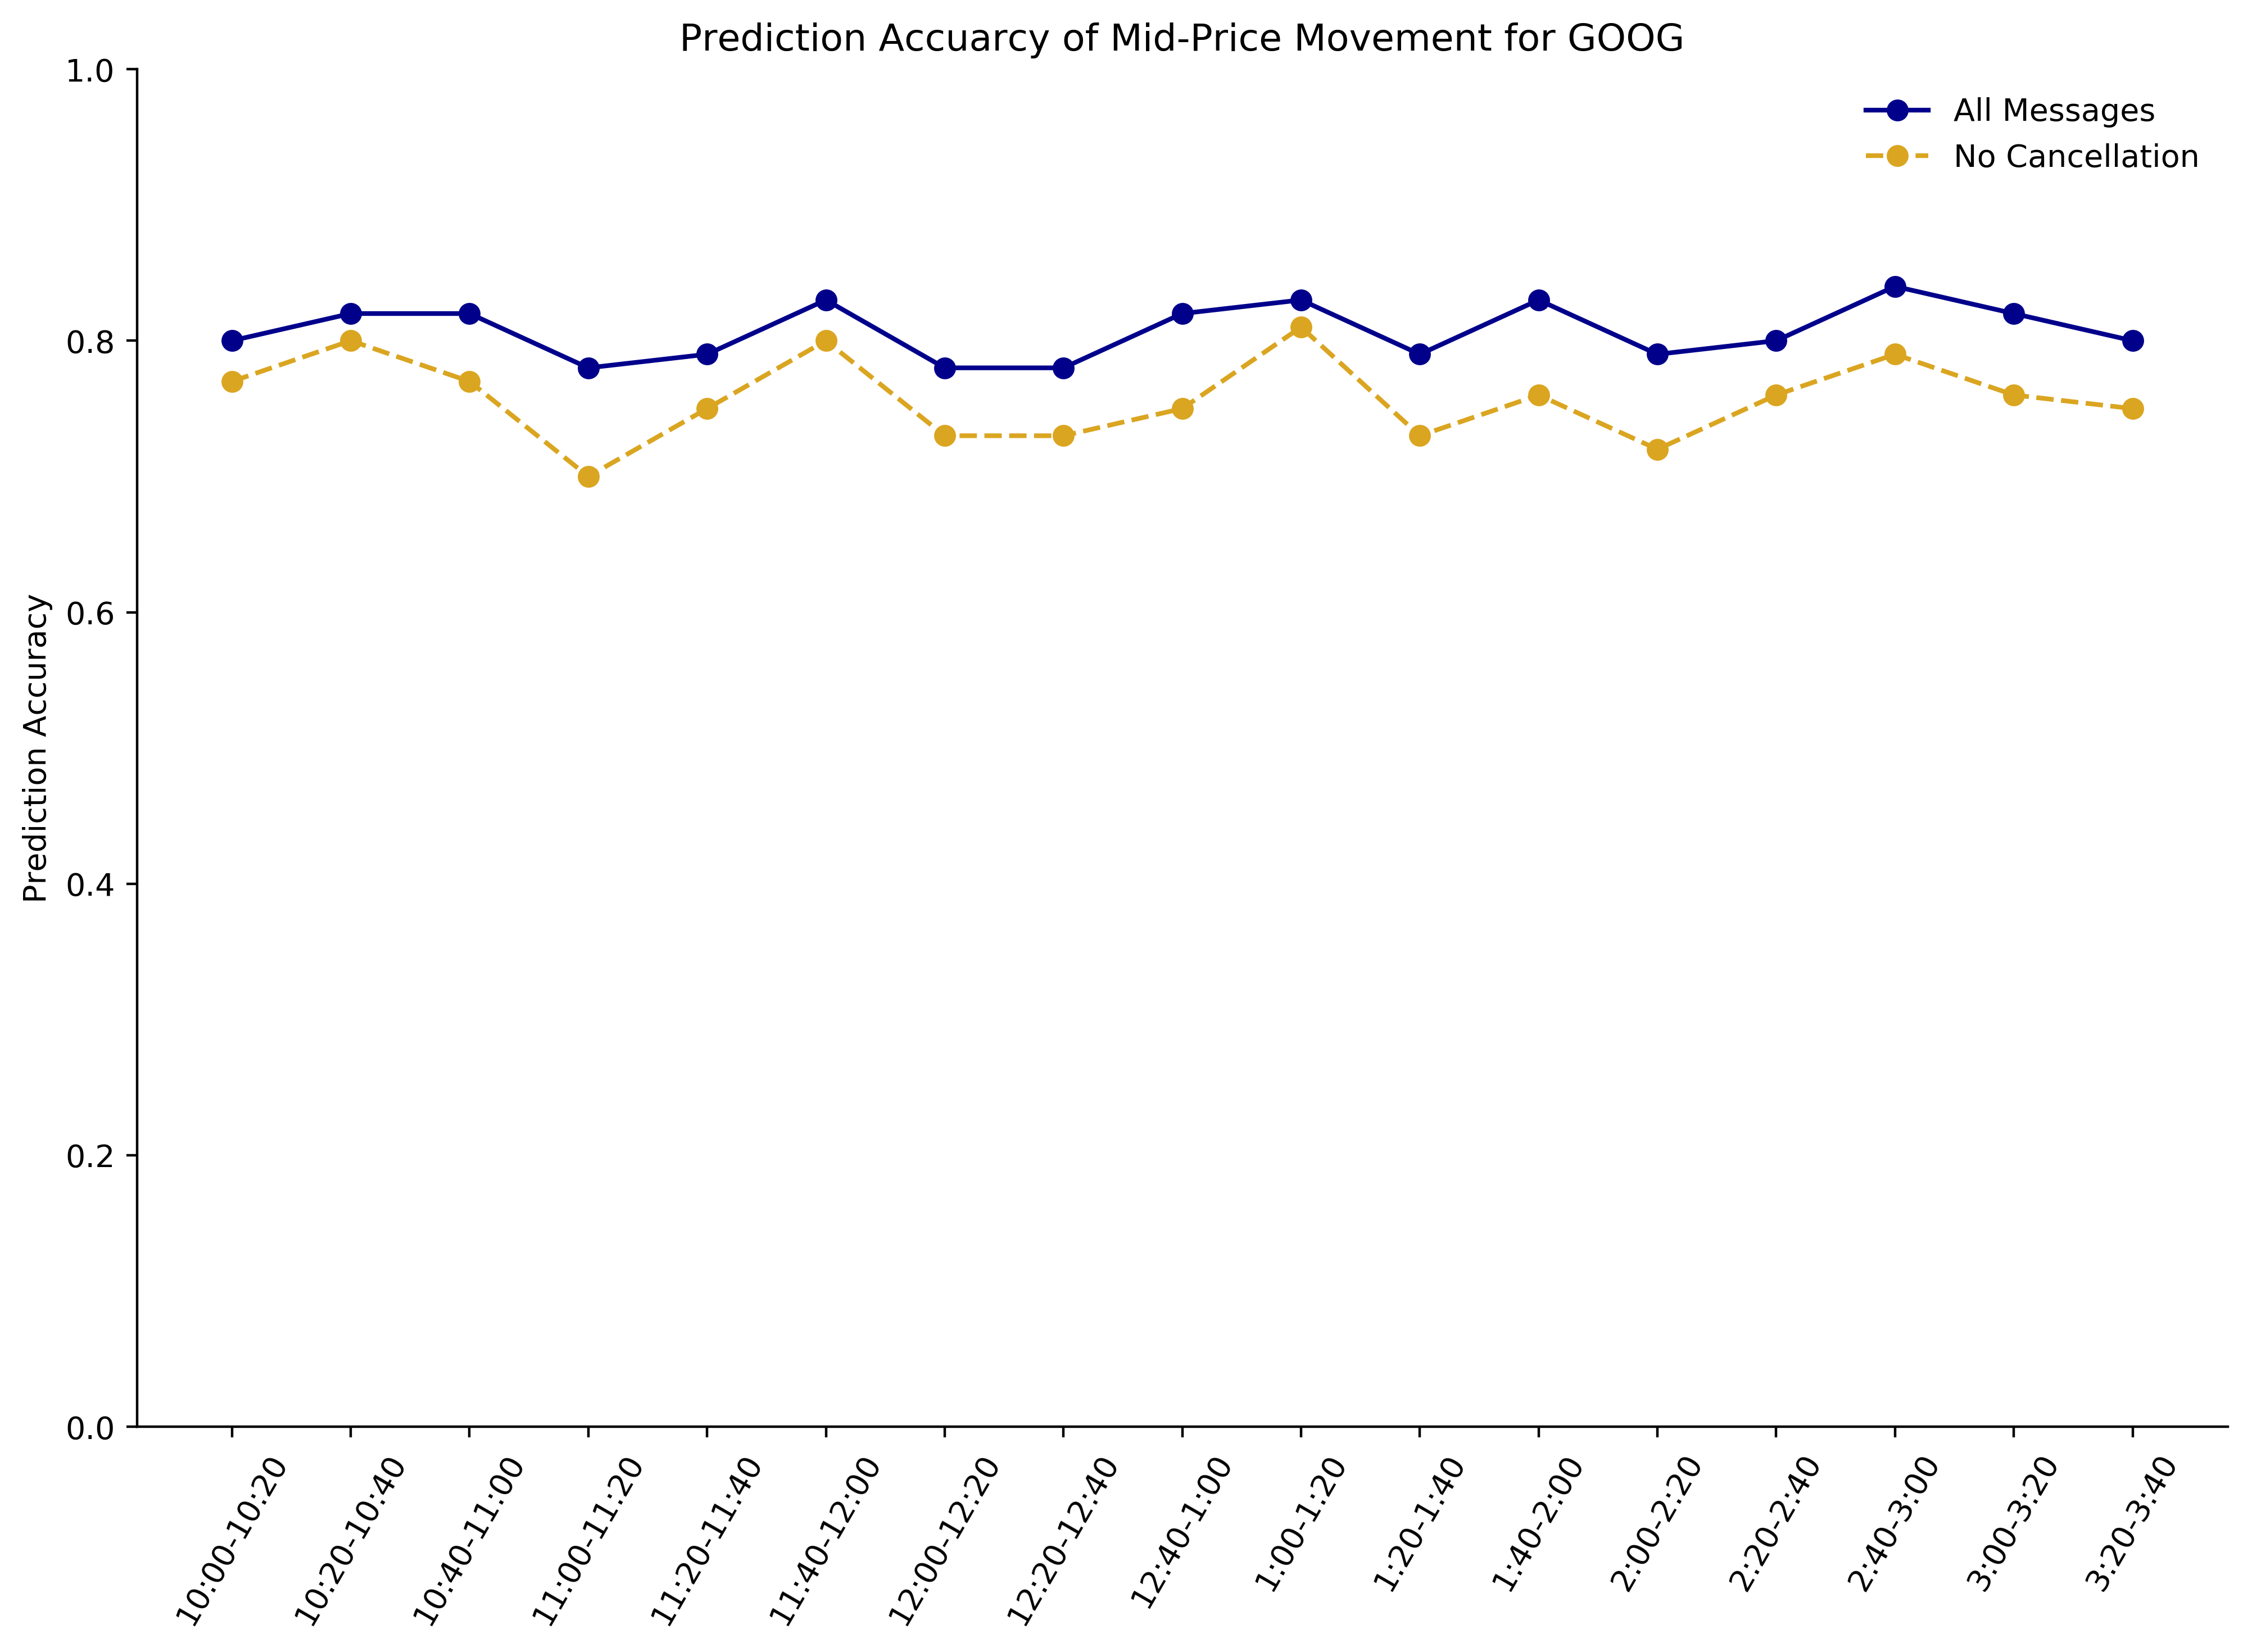

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8),dpi=400)

y = accs_table_simple["Accuracy"]
x = np.arange(len(y))
ax.plot(x, y,marker='o',color='darkblue',label='All Messages')

y = test_accs_simple_NoCancel
x = np.arange(len(y))
ax.plot(x, y, ls="--",marker='o',color='goldenrod',label='No Cancellation')

ax.legend(frameon=False)
ax.set_ylabel('Prediction Accuracy')

labels = accs_table_simple["Training Session"]
plt.xticks(x, labels, rotation=60)
# grab stock name
stock = file_path.split(".")[0].split("_")[-1]
titleName = 'Prediction Accuarcy of Mid-Price Movement for ' + stock
plt.title(titleName)
# show the plot
plt.ylim([0,1])
plt.show()